In [1]:
# Just disables the warning, doesn't enable AVX/FMA
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as pd
import keras
from pprint import pprint
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,Embedding,Flatten,LSTM,Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

from keras.preprocessing.text import Tokenizer,one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# pd.options.mode.chained_assignment = None  
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    
    plt.xlabel('Predicted label')

# vocab_size =    263857

Using TensorFlow backend.


In [2]:
[X_train_snippet, X_test_snippet,\
X_train_token, X_test_token, \
X_train_token_features, X_test_token_features, \
y_train, y_test,\
# eid_train, eid_test,\
# idx_train, idx_test,\
token_train, token_test,\
# snippet_train, snippet_test,\
label_train,label_test] = [0,0,0,0,0,0,0,0,0,0,0,0,]

data_sets = [X_train_snippet, X_test_snippet,\
X_train_token, X_test_token, \
X_train_token_features, X_test_token_features, \
y_train, y_test,\
# eid_train, eid_test,\
# idx_train, idx_test,\
token_train, token_test,\
# snippet_train, snippet_test,\
label_train,label_test]

# data_sets_name = ["X_train_snippet", "X_test_snippet",\
# "X_train_token", "X_test_token", \
# "X_train_token_features", "X_test_token_features", \
# "y_train", "y_test",'token_train',\
# "token_test","label_train","label_test"]


# np.savez('mat.npz', *data_sets)
def load_data(data_sets):
    data_sets_list = data_sets
    container = np.load('mat.npz')
    for i,data_set in enumerate(data_sets):
        yield(container['arr_'+str(i)])
#         print (data_sets_name[i],data_set)
#     return data_Sets
[X_train_snippet, X_test_snippet,\
X_train_token, X_test_token, \
X_train_token_features, X_test_token_features, \
y_train, y_test,\
# eid_train, eid_test,\
# idx_train, idx_test,\
token_train, token_test,\
# snippet_train, snippet_test,\
label_train,label_test] = list(load_data(data_sets))

In [ ]:
# list(zip(eid_train,idx_train,token_train,snippet_train,label_train))



In [3]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)
print (sample_weight)

[2.02428958 0.66401083 0.66401083 ... 0.66401083 0.66401083 0.66401083]


# functional model

In [4]:
vocab_size =264441
#functional model
import tensorflow as tf

print('tf version' , tf.__version__) 
print('keras version',keras.__version__) 
from keras.layers import * #Input, Embedding, LSTM, Dense
from keras.models import * #Model
from keras.callbacks import TensorBoard

sess = tf.Session()
keras.backend.clear_session() 

def get_model(hand_crafted_features):
    if hand_crafted_features:
        snippet_input = Input(shape=(21,),dtype='float32',  name='snippet_input')
        snippet_Embedding = Embedding(output_dim=300, 
                                      input_dim=vocab_size, 
                                      input_length=21, 
                                      name = 'snippet_Embedding'
                                     )(snippet_input)

        # snippet_Embedding = Bidirectional(CuDNNLSTM(32,return_sequences = True))(snippet_Embedding)
        snippet_Embedding = Bidirectional(LSTM(300,return_sequences = False,name="snippet_lstm"),name = 'snippet_bidirectional_lstm')(snippet_Embedding)

        snippet_Embedding = Dense(300, activation='relu')(snippet_Embedding)

        #####################################################################
        token_input = Input(shape=(1,), dtype='float32',  name='token_input')
        token_features_input = Input(shape=(9,), dtype='float32',  name='token_features_input')
        token_input_concat = Concatenate(axis=1,
                                     name = 'token_Embedding_and_token_features'
                                     )([token_input,token_features_input])

        token_Embedding = Embedding(output_dim=300, 
                                    input_dim=vocab_size, 
                                    input_length=10,
                                    name = 'token_Embedding'
                                   )(token_input_concat)

        # token_Embedding = Bidirectional(CuDNNLSTM(32,return_sequences = True))(token_Embedding)
        token_Embedding = Bidirectional(LSTM(300,return_sequences = False,name="token_lstm"),name="token_bidirectional_lstm")(token_Embedding)
        token_Embedding = Dense(300, activation='relu',name = 'token_dense')(token_Embedding)



        x = Dot(axes=1,name = 'all_dot')([snippet_Embedding, token_Embedding])
        x = Concatenate(axis=1,name = 'all_concat')([x,token_features_input])

        # We stack a deep densely-connected network on top
        # x = Dense(300, activation='relu')(x)
        x = Dense(300, activation='relu',name = 'all_dense')(x)
        x = Dropout(0.33,name = 'all_dropout')(x)

        # And finally we add the main logistic regression layer
        snippet_label = Dense(1, activation='sigmoid', name='snippet_label')(x)


        model = Model(inputs=[snippet_input, token_input,token_features_input], outputs=[snippet_label])

        model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['acc'])
        return model
    else:

        snippet_input = Input(shape=(21,),dtype='float32',  name='snippet_input')
        snippet_Embedding = Embedding(output_dim=300, 
                                      input_dim=vocab_size, 
                                      input_length=21, 
                                      name = 'snippet_Embedding'
                                     )(snippet_input)

        # snippet_Embedding = Bidirectional(CuDNNLSTM(32,return_sequences = True))(snippet_Embedding)
        snippet_Embedding = Bidirectional(LSTM(300,return_sequences = False))(snippet_Embedding)

        snippet_Embedding = Dense(300, activation='relu')(snippet_Embedding)

        #####################################################################
        token_input = Input(shape=(1,), dtype='float32',  name='token_input')

        token_Embedding = Embedding(output_dim=300, 
                                    input_dim=vocab_size, 
                                    input_length=10,
                                    name = 'token_Embedding'
                                   )(token_input)

        # token_Embedding = Bidirectional(CuDNNLSTM(32,return_sequences = True))(token_Embedding)
        token_Embedding = Bidirectional(LSTM(300,return_sequences = False))(token_Embedding)
        token_Embedding = Dense(300, activation='relu')(token_Embedding)



        x = Dot(axes=1)([snippet_Embedding, token_Embedding])

        # We stack a deep densely-connected network on top
        # x = Dense(300, activation='relu')(x)
        x = Dense(300, activation='relu')(x)
        x = Dropout(0.33)(x)

        # And finally we add the main logistic regression layer
        snippet_label = Dense(1, activation='sigmoid', name='snippet_label')(x)


        model = Model(inputs=[snippet_input, token_input], outputs=[snippet_label])

        model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['acc'])
        return model
model_hand_crafted_features = get_model(True)
model_without_hand_crafted_features = get_model(False)
# print(model_hand_crafted_features.summary())


('tf version', '1.9.0')
('keras version', '2.2.2')


In [5]:
# print(model_hand_crafted_features.summary())
# print(model_without_hand_crafted_features.summary())

In [6]:
model_hand_crafted_features.load_weights("model_KerasFunctional_WITH_Handmade_features")
model_without_hand_crafted_features.load_weights("model_KerasFunctional_WITHOUT_Handmade_features")

In [11]:
from keras.utils.vis_utils import plot_model
plot_model(model_hand_crafted_features,to_file='model_plot_model_hand_crafted_features.png',show_shapes = True, show_layer_names=True)

plot_model(model_without_hand_crafted_features,to_file='model_plot_model_without_hand_crafted_features.png',show_shapes = True, show_layer_names=True)



In [12]:
o = model_hand_crafted_features.evaluate([X_test_snippet,X_test_token,X_test_token_features], y_test, verbose=1)
print(o)

99999/99999 [==============================] - 148s 1ms/step
[0.14899106947517451, 0.9876798767898272]


In [13]:
o = model_without_hand_crafted_features.evaluate([X_test_snippet,X_test_token], y_test, verbose=1)
print(o)

99999/99999 [==============================] - 114s 1ms/step
[0.09265866135435853, 0.987549875498755]


In [ ]:
df[df['Surname'].str.len() > 9]

In [43]:
vocab = pd.read_csv('vocab.csv',delimiter = ',',delim_whitespace=False,header=0)
token_dict = pd.Series(vocab.token.values,index=vocab.index).to_dict()

def get_token(index):
    try:
        return token_dict[index]
    except:
        return 'ERROR'
    
# making log folder 
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
path = 'log/'+timestr+'/'
import os
if not os.path.exists(path):
    os.makedirs(path)
def get_token(index):
    try:
        return token_dict[index]
    except:
        return 'ERROR'    
vocab_index = X_train_token
metadata_df = pd.DataFrame({'vocab_index': vocab_index,'vocab_label':y_train})
metadata_df['vocab_token'] = metadata_df.vocab_index.apply(get_token)

# print(metadata_df)
metadata_df.to_csv(path +'/metatdata.tsv', sep='\t')


# chack point saving
from keras.callbacks import ModelCheckpoint
# checkpoint = ModelCheckpoint("log/weights-improvement-{epoch:02d}-{acc:.2f}.hdf5", 
#                              monitor='val_acc', 
#                              verbose=1, 
#                              save_best_only=True, 
#                              mode='max')
# checkpoint = ModelCheckpoint("log/"+timestr+"/weights-improvement-best.hdf5", 
#                              monitor='val_acc', 
#                              verbose=1, 
#                              save_best_only=True, 
#                              mode='max')
#tensorboard

embeddingsMetadata = { 'snippet_Embedding': 'metatdata.tsv','token_Embedding': 'metatdata.tsv'}
# embeddingsMetadata = { 'token_Embedding': 'log/metatdata.tsv' }
tensorBoardCallBack = keras.callbacks.TensorBoard(log_dir='log/'+timestr+'/', 
                                         histogram_freq=1,
                                         write_grads = True,
                                         batch_size = 1028,
                                         embeddings_freq = 1,
                                         embeddings_layer_names = ['snippet_Embedding' , 'token_Embedding'],
                                         embeddings_metadata = embeddingsMetadata,
                                         embeddings_data = [X_train_snippet,X_train_token,X_train_token_features],
                                         write_graph=True, 
                                         write_images=True)

# tbCallBack.set_model(model) # not needed in the latest version
#vcallback list
# lrCallBack = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=0)
# stopCallback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='auto', baseline=0)

# callbacks_list = [tensorBoardCallBack,checkpoint,lrCallBack]
# callbacks_list = [tensorBoardCallBack,lrCallBack]
# callbacks_list = [checkpoint,lrCallBack]
callbacks_list = [tensorBoardCallBack]
# callbacks_list = [lrCallBack,stopCallback]
#fit model
# model.load_weights("log/20180731-184804/weights-improvement-best.hdf5")
history = model_hand_crafted_features.fit({'snippet_input': X_train_snippet, 'token_input': X_train_token,'token_features_input':X_train_token_features},
          {'snippet_label': y_train},
          verbose = 1,
          epochs=1,
          batch_size=pow(2,9),
#           shuffle= True,
          validation_split =0.1,
          sample_weight =sample_weight,
          callbacks=callbacks_list
         )
print history.history
print('done')

Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 10s 11ms/step - loss: 3.0193 - acc: 0.8933 - val_loss: 1.0327e-07 - val_acc: 1.0000
{'acc': [0.8933333269755046], 'loss': [3.0193102280878357], 'val_acc': [1.0], 'val_loss': [1.0326930066639761e-07]}
done


In [14]:
from sklearn.metrics import classification_report
import numpy as np
Y_test = y_test #np.reshape(y_test, (-1, 1))
# Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred_model_hand_crafted_features = model_hand_crafted_features.predict([X_test_snippet,X_test_token,X_test_token_features], verbose=1)
y_pred_model_hand_crafted_features_ =  np.digitize(y_pred_model_hand_crafted_features, np.array([0.5]))
print(classification_report(Y_test, y_pred_model_hand_crafted_features_))

99999/99999 [==============================] - 147s 1ms/step
             precision    recall  f1-score   support

          0       0.99      0.99      0.99     75307
          1       0.98      0.97      0.97     24692

avg / total       0.99      0.99      0.99     99999



In [15]:
from sklearn.metrics import classification_report
import numpy as np
Y_test = y_test #np.reshape(y_test, (-1, 1))
# Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred_model_without_hand_crafted_features = model_without_hand_crafted_features.predict([X_test_snippet,X_test_token], verbose=1)
y_pred_model_without_hand_crafted_features_ =  np.digitize(y_pred_model_without_hand_crafted_features, np.array([0.5]))
print(classification_report(Y_test, y_pred_model_without_hand_crafted_features_))

99999/99999 [==============================] - 113s 1ms/step
             precision    recall  f1-score   support

          0       0.99      0.99      0.99     75307
          1       0.98      0.97      0.97     24692

avg / total       0.99      0.99      0.99     99999



In [17]:
from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import auc

fpr_keras_hand_crafted_features, tpr_keras_hand_crafted_features, thresholds_keras_hand_crafted_features = roc_curve(y_test, 
                                                   y_pred_model_hand_crafted_features)
auc_keras_hand_crafted_features = auc(fpr_keras_hand_crafted_features, 
                                      tpr_keras_hand_crafted_features)
print auc_keras_hand_crafted_features

fpr_keras_pr_hand_crafted_features, tpr_keras_pr_hand_crafted_features, thresholds_keras_pr_hand_crafted_features = precision_recall_curve(y_test, 
                                                                   y_pred_model_hand_crafted_features)
auc_keras_pr_hand_crafted_features = auc(fpr_keras_pr_hand_crafted_features, 
                                         tpr_keras_pr_hand_crafted_features, 
                                         reorder = True)
print auc_keras_pr_hand_crafted_features
# 0.9951268312090964
# 0.7404782974199036

0.9957936486908274
0.7412995034325929


In [18]:
from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import auc

fpr_keras_without_hand_crafted_features, tpr_keras_without_hand_crafted_features, thresholds_keras_without_hand_crafted_features = roc_curve(y_test, y_pred_model_without_hand_crafted_features)
auc_keras_without_hand_crafted_features = auc(fpr_keras_without_hand_crafted_features, tpr_keras_without_hand_crafted_features)
print auc_keras_without_hand_crafted_features

fpr_keras_pr_without_hand_crafted_features, tpr_keras_pr_without_hand_crafted_features, thresholds_keras_pr_without_hand_crafted_features = precision_recall_curve(y_test, y_pred_model_without_hand_crafted_features)
auc_keras_pr_without_hand_crafted_features = auc(fpr_keras_pr_without_hand_crafted_features, tpr_keras_pr_without_hand_crafted_features, reorder = True)
print auc_keras_pr_without_hand_crafted_features
# 0.9951268312090964
# 0.7404782974199036

0.9970108142207491
0.7468646787083274


In [56]:
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=100, n_estimators=100,verbose=1)
rf.fit(X_train_snippet, y_train)
y_pred_rf = rf.predict_proba(X_test_snippet)[:, 1]

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)
print auc_rf

fpr_rf_pr, tpr_rf_pr, thresholds_rf_pr = precision_recall_curve(y_test, y_pred_rf)
auc_rf_pr = auc(fpr_rf_pr, tpr_rf_pr,reorder = True)
print auc_rf_pr

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 10.5min finished


0.6070063273007457
0.08346005819017506


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.9s finished


In [57]:
print(classification_report(Y_test, np.digitize(y_pred_rf, np.array([0.5]))))
#              precision    recall  f1-score   support

#           0       0.75      1.00      0.86    150638
#           1       0.68      0.00      0.01     49360

# avg / total       0.74      0.75      0.65    199998

             precision    recall  f1-score   support

          0       0.75      1.00      0.86     75307
          1       0.72      0.01      0.01     24692

avg / total       0.75      0.75      0.65     99999



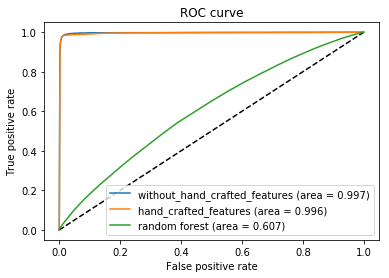

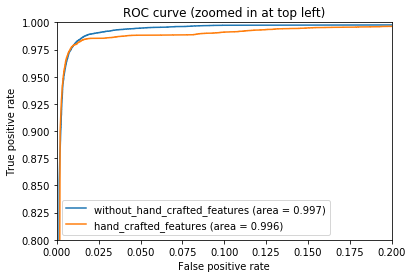

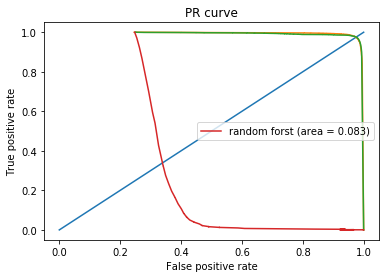

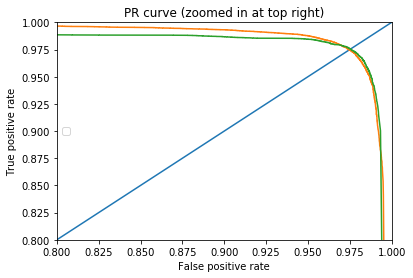

In [60]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_without_hand_crafted_features, tpr_keras_without_hand_crafted_features, label='without_hand_crafted_features (area = {:.3f})'.format(auc_keras_without_hand_crafted_features))
plt.plot(fpr_keras_hand_crafted_features, tpr_keras_hand_crafted_features, label='hand_crafted_features (area = {:.3f})'.format(auc_keras_hand_crafted_features))
plt.plot(fpr_rf, tpr_rf, label='random forest (area = {:.3f})'.format(auc_rf))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()



# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_without_hand_crafted_features, tpr_keras_without_hand_crafted_features, label='without_hand_crafted_features (area = {:.3f})'.format(auc_keras_without_hand_crafted_features))
plt.plot(fpr_keras_hand_crafted_features, tpr_keras_hand_crafted_features, label='hand_crafted_features (area = {:.3f})'.format(auc_keras_hand_crafted_features))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()



plt.figure(3)
plt.plot([0, 1], [0, 1])
plt.plot(fpr_keras_pr_without_hand_crafted_features, tpr_keras_pr_without_hand_crafted_features, label='_pr_without_hand_crafted_features (area = {:.3f})'.format(auc_keras_pr_without_hand_crafted_features))
plt.plot(fpr_keras_pr_hand_crafted_features, tpr_keras_pr_hand_crafted_features, label='_pr_hand_crafted_features (area = {:.3f})'.format(auc_keras_pr_hand_crafted_features))
plt.plot(fpr_rf_pr, tpr_rf_pr, label='random forst (area = {:.3f})'.format(auc_rf_pr))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('PR curve')
plt.legend(loc='best')
plt.show()

plt.figure(4)
plt.xlim(0.8, 1)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1])
plt.plot(fpr_keras_pr_without_hand_crafted_features, tpr_keras_pr_without_hand_crafted_features, label='_pr_without_hand_crafted_features (area = {:.3f})'.format(auc_keras_pr_without_hand_crafted_features))
plt.plot(fpr_keras_pr_hand_crafted_features, tpr_keras_pr_hand_crafted_features, label='_pr_hand_crafted_features (area = {:.3f})'.format(auc_keras_pr_hand_crafted_features))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('PR curve (zoomed in at top right)')
plt.legend(loc='best')
plt.show()



# graphs per class

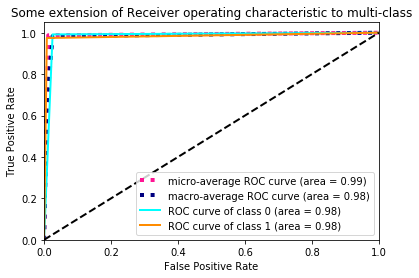

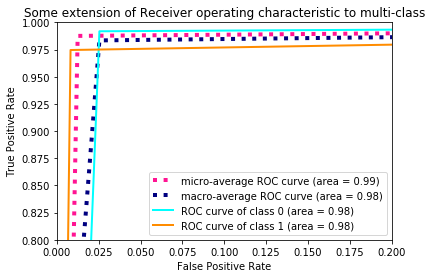

In [48]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc


from sklearn.preprocessing import label_binarize
y_test_multiclass = (label_binarize(y_test, classes=[0,0.5,1]))
y_test_multiclass =  np.delete(y_test_multiclass,1,1)

y_pred_multiclass = (label_binarize(y_pred_model_without_hand_crafted_features_, classes=[0,0.5,1]))
y_pred_multiclass =  np.delete(y_pred_multiclass,1,1)


# Plot linewidth.
lw = 2
n_classes = 2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_multiclass[:, i], y_pred_multiclass[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_multiclass.ravel(), y_pred_multiclass.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

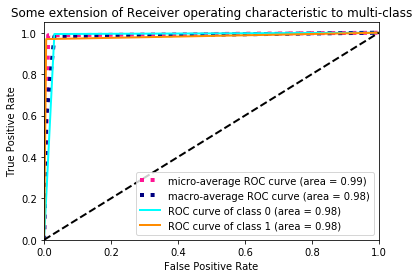

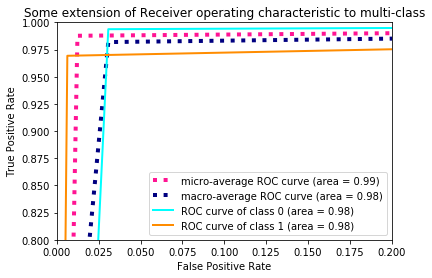

In [49]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc


from sklearn.preprocessing import label_binarize
y_test_multiclass = (label_binarize(y_test, classes=[0,0.5,1]))
y_test_multiclass =  np.delete(y_test_multiclass,1,1)

y_pred_multiclass = (label_binarize(y_pred_model_hand_crafted_features_, classes=[0,0.5,1]))
y_pred_multiclass =  np.delete(y_pred_multiclass,1,1)


# Plot linewidth.
lw = 2
n_classes = 2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_multiclass[:, i], y_pred_multiclass[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_multiclass.ravel(), y_pred_multiclass.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Confusion matrix, without normalization
[[74834   473]
 [  759 23933]]
Normalized confusion matrix
[[0.99 0.01]
 [0.03 0.97]]


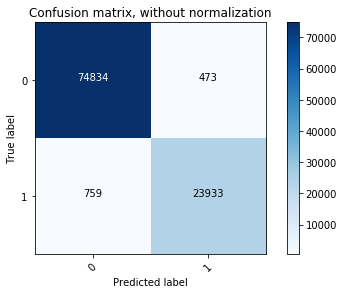

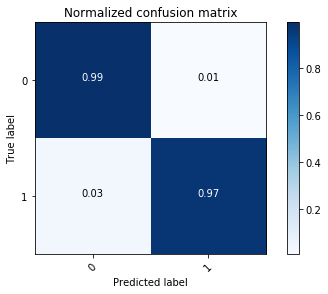

In [50]:

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_model_hand_crafted_features_)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[74690   617]
 [  628 24064]]
Normalized confusion matrix
[[0.99 0.01]
 [0.03 0.97]]


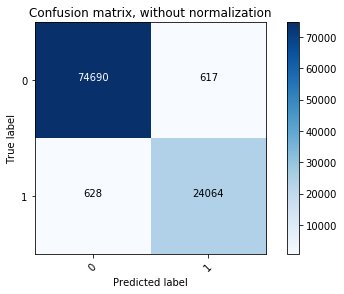

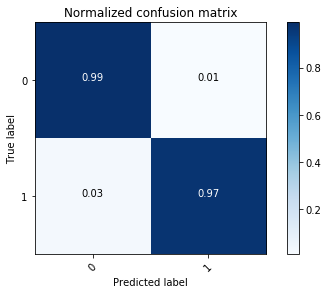

In [53]:
# Compute confusion matrix
# y_pred_rf_ = np.digitize(y_pred_rf, np.array([0.5]))
cnf_matrix = confusion_matrix(y_test, y_pred_model_without_hand_crafted_features_)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()